Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6958 │ Recall@10: 0.1665 │ NDCG@10: 0.0895


Epoch 2:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.6844 │ Recall@10: 0.2710 │ NDCG@10: 0.1856


Epoch 3:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.6688 │ Recall@10: 0.3700 │ NDCG@10: 0.2806


Epoch 4:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.6540 │ Recall@10: 0.4240 │ NDCG@10: 0.3280


Epoch 5:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.6424 │ Recall@10: 0.4745 │ NDCG@10: 0.3650


Epoch 6:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.6316 │ Recall@10: 0.5150 │ NDCG@10: 0.3952


Epoch 7:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.6220 │ Recall@10: 0.5445 │ NDCG@10: 0.4082


Epoch 8:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.6135 │ Recall@10: 0.5790 │ NDCG@10: 0.4219


Epoch 9:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.6035 │ Recall@10: 0.6000 │ NDCG@10: 0.4292


Epoch 10:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.5909 │ Recall@10: 0.6230 │ NDCG@10: 0.4440


Epoch 11:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.5726 │ Recall@10: 0.6385 │ NDCG@10: 0.4486


Epoch 12:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.5465 │ Recall@10: 0.6430 │ NDCG@10: 0.4423


Epoch 13:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.5051 │ Recall@10: 0.6295 │ NDCG@10: 0.4327


Epoch 14:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.4455 │ Recall@10: 0.6110 │ NDCG@10: 0.4227


Epoch 15:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.3741 │ Recall@10: 0.6085 │ NDCG@10: 0.4165


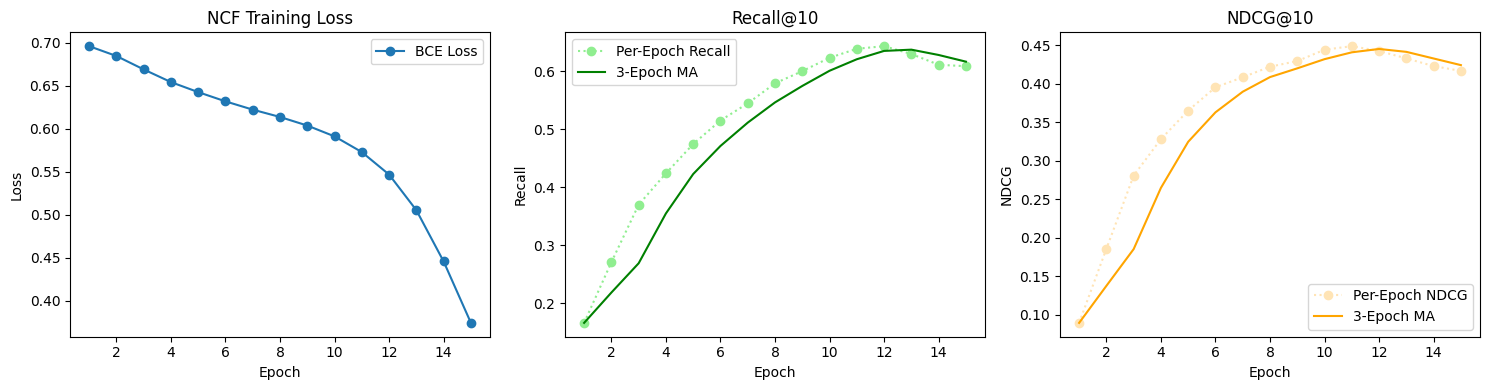

In [1]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 15  # NCF often converges faster than BPR
EMB_DIM = 64  # Start with a reasonable embedding size for NCF
MLP_LAYERS = [EMB_DIM * 2, 256, 128, 64] # Input layer is 2x embedding dim (user+item)
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Load & Filter Ratings ────────────────────────────────────────
try:
    ratings_raw = pd.read_csv("data/Ratings.csv")
except FileNotFoundError:
    print("Error: 'data/Ratings.csv' not found.")
    exit()

ratings_raw = ratings_raw[ratings_raw["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
def train_test_split(df):
    df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
    train_df = df[df['rank_latest'] != 1]
    test_df = df[df['rank_latest'] == 1]
    return train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

train_df, test_df = train_test_split(ratings_raw)

# ─── 4 │ Encode IDs ───────────────────────────────────────────────────
user2idx = {u: i for i, u in enumerate(train_df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(train_df["ISBN"].unique())}

train_df["user_idx"] = train_df["User-ID"].map(user2idx)
train_df["book_idx"] = train_df["ISBN"].map(book2idx)
test_df["user_idx"] = test_df["User-ID"].map(user2idx)
test_df["book_idx"] = test_df["ISBN"].map(book2idx)

test_df = test_df.dropna().astype({"user_idx": int, "book_idx": int})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users, n_books = len(user2idx), len(book2idx)

# ─── 5 │ NCF Dataset (Pointwise Labels) ───────────────────────────────
class NCFDataset(Dataset):
    def __init__(self, df, n_books, is_training=True):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.n_books = n_books
        self.is_training = is_training
        if self.is_training:
            self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        item_pos = self.items[idx]
        
        if self.is_training:
            # For every positive sample, create one negative sample
            item_neg = np.random.randint(self.n_books)
            while (user, item_neg) in self.user_item_set:
                item_neg = np.random.randint(self.n_books)
            
            return (
                torch.tensor(user, dtype=torch.long),
                torch.tensor([item_pos, item_neg], dtype=torch.long)
            )
        else:
            # For testing, we only need the positive user-item pair
            return (
                torch.tensor(user, dtype=torch.long),
                torch.tensor(item_pos, dtype=torch.long)
            )

def collate_ncf(batch):
    users, items = zip(*batch)
    # Stack along a new dimension, then reshape
    users = torch.stack(users).repeat_interleave(2) # [u1, u1, u2, u2, ...]
    items = torch.stack(items).flatten() # [i1_pos, i1_neg, i2_pos, i2_neg, ...]
    # Create labels: 1 for positive, 0 for negative
    labels = torch.tensor([1, 0] * (len(batch)), dtype=torch.float32)
    return users, items, labels


train_ds = NCFDataset(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE // 2, shuffle=True, collate_fn=collate_ncf, num_workers=0)


# ─── 6 │ NCF Model Definition ─────────────────────────────────────────
class NCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, mlp_layers):
        super().__init__()
        # GMF Path
        self.gmf_user_embedding = nn.Embedding(n_users, emb_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, emb_dim)

        # MLP Path
        self.mlp_user_embedding = nn.Embedding(n_users, emb_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, emb_dim)
        
        mlp_modules = []
        for i in range(len(mlp_layers) - 1):
            mlp_modules.append(nn.Linear(mlp_layers[i], mlp_layers[i+1]))
            mlp_modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*mlp_modules)

        # Prediction Layer
        # Input size is emb_dim (from GMF) + last mlp_layer size
        predict_size = emb_dim + mlp_layers[-1]
        self.predict_layer = nn.Linear(predict_size, 1)

    def forward(self, user, item):
        # GMF Path
        gmf_user_emb = self.gmf_user_embedding(user)
        gmf_item_emb = self.gmf_item_embedding(item)
        gmf_vector = gmf_user_emb * gmf_item_emb

        # MLP Path
        mlp_user_emb = self.mlp_user_embedding(user)
        mlp_item_emb = self.mlp_item_embedding(item)
        mlp_input = torch.cat([mlp_user_emb, mlp_item_emb], dim=-1)
        mlp_vector = self.mlp(mlp_input)
        
        # Concatenate GMF and MLP paths
        final_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        
        # Final prediction
        prediction = self.predict_layer(final_vector)
        return prediction.squeeze()

model = NCF(n_users, n_books, EMB_DIM, MLP_LAYERS).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss() # Use Binary Cross-Entropy for NCF

# ─── 7 │ Evaluation Function ──────────────────────────────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            seen_books = train_history.get(u_idx, set())
            
            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = torch.tensor([pos_b_idx] + neg_b_indices, device=DEVICE)
            u_tensor = torch.tensor([u_idx] * len(eval_b_indices), device=DEVICE)
            scores = model(u_tensor, eval_b_indices).cpu().numpy()

            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 8 │ Training & Evaluation Loop ──────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, items, labels in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        users, items, labels = users.to(DEVICE), items.to(DEVICE), labels.to(DEVICE)
        
        opt.zero_grad()
        predictions = model(users, items)
        loss = loss_fn(predictions, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")

# ─── 9 │ Plotting Results ─────────────────────────────────────────────
window_size = 3
recall_ma = pd.Series(recall_hist).rolling(window_size, min_periods=1).mean()
ndcg_ma = pd.Series(ndcg_hist).rolling(window_size, min_periods=1).mean()

plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss_hist, marker='o', linestyle='-', label='BCE Loss')
plt.title("NCF Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

# Recall@10
plt.subplot(1, 3, 2)
plt.plot(epochs_range, recall_hist, marker='o', linestyle=':', color='lightgreen', label='Per-Epoch Recall')
plt.plot(epochs_range, recall_ma, color='green', label=f'{window_size}-Epoch MA')
plt.title("Recall@10")
plt.xlabel("Epoch"); plt.ylabel("Recall")
plt.legend()

# NDCG@10
plt.subplot(1, 3, 3)
plt.plot(epochs_range, ndcg_hist, marker='o', linestyle=':', color='moccasin', label='Per-Epoch NDCG')
plt.plot(epochs_range, ndcg_ma, color='orange', label=f'{window_size}-Epoch MA')
plt.title("NDCG@10")
plt.xlabel("Epoch"); plt.ylabel("NDCG")
plt.legend()

plt.tight_layout()
plt.show()

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6984 │ Recall@10: 0.1995 │ NDCG@10: 0.1052


Epoch 2:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.6813 │ Recall@10: 0.3055 │ NDCG@10: 0.2229


Epoch 3:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.6646 │ Recall@10: 0.3885 │ NDCG@10: 0.2931


Epoch 4:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.6516 │ Recall@10: 0.4445 │ NDCG@10: 0.3442


Epoch 5:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.6415 │ Recall@10: 0.4805 │ NDCG@10: 0.3689


Epoch 6:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.6323 │ Recall@10: 0.5195 │ NDCG@10: 0.3938


Epoch 7:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.6243 │ Recall@10: 0.5560 │ NDCG@10: 0.4086


Epoch 8:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.6168 │ Recall@10: 0.5780 │ NDCG@10: 0.4227


Epoch 9:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.6077 │ Recall@10: 0.6115 │ NDCG@10: 0.4375


Epoch 10:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.5978 │ Recall@10: 0.6160 │ NDCG@10: 0.4449


Epoch 11:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.5842 │ Recall@10: 0.6155 │ NDCG@10: 0.4373


Epoch 12:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.5647 │ Recall@10: 0.6285 │ NDCG@10: 0.4436


Epoch 13:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.5350 │ Recall@10: 0.6305 │ NDCG@10: 0.4413


Epoch 14:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.4870 │ Recall@10: 0.6215 │ NDCG@10: 0.4288


Epoch 15:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.4216 │ Recall@10: 0.6210 │ NDCG@10: 0.4322


Epoch 16:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 16 │ Loss: 0.3533 │ Recall@10: 0.6125 │ NDCG@10: 0.4169


Epoch 17:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 17 │ Loss: 0.2555 │ Recall@10: 0.6170 │ NDCG@10: 0.4248


Epoch 18:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 18 │ Loss: 0.2048 │ Recall@10: 0.6115 │ NDCG@10: 0.4184


Epoch 19:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 19 │ Loss: 0.1766 │ Recall@10: 0.6140 │ NDCG@10: 0.4166


Epoch 20:   0%|          | 0/174 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 20 │ Loss: 0.1548 │ Recall@10: 0.6105 │ NDCG@10: 0.4183


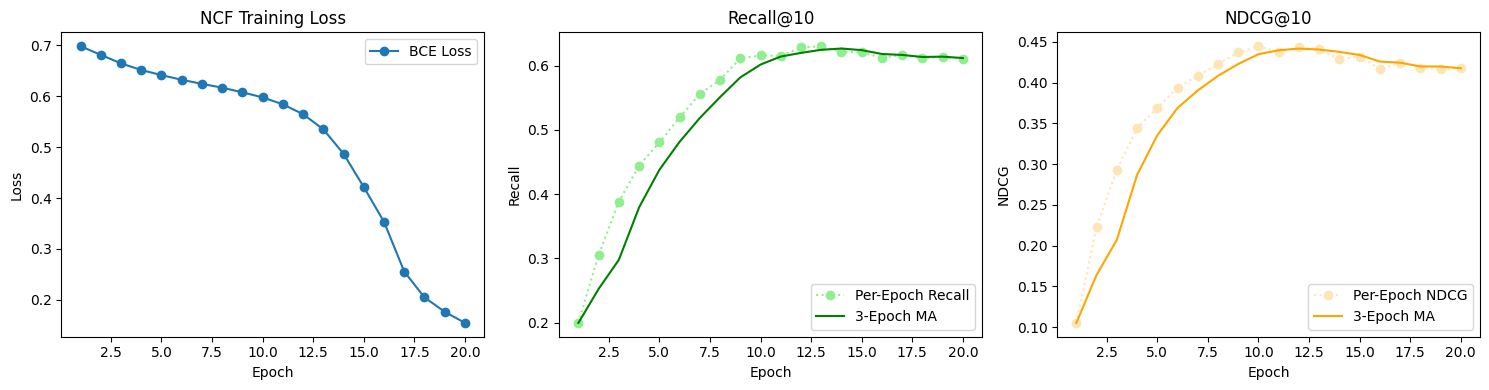

In [3]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 20 # Increased epochs slightly to give scheduler time to work
EMB_DIM = 64
# Deeper MLP Layers: added a 32-neuron layer
MLP_LAYERS = [EMB_DIM * 2, 256, 128, 64, 32] 
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Load & Filter Ratings ────────────────────────────────────────
try:
    ratings_raw = pd.read_csv("data/Ratings.csv")
except FileNotFoundError:
    print("Error: 'data/Ratings.csv' not found.")
    exit()

ratings_raw = ratings_raw[ratings_raw["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
def train_test_split(df):
    df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
    train_df = df[df['rank_latest'] != 1]
    test_df = df[df['rank_latest'] == 1]
    return train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

train_df, test_df = train_test_split(ratings_raw)

# ─── 4 │ Encode IDs ───────────────────────────────────────────────────
user2idx = {u: i for i, u in enumerate(train_df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(train_df["ISBN"].unique())}

train_df["user_idx"] = train_df["User-ID"].map(user2idx)
train_df["book_idx"] = train_df["ISBN"].map(book2idx)
test_df["user_idx"] = test_df["User-ID"].map(user2idx)
test_df["book_idx"] = test_df["ISBN"].map(book2idx)

test_df = test_df.dropna().astype({"user_idx": int, "book_idx": int})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users, n_books = len(user2idx), len(book2idx)

# ─── 5 │ NCF Dataset (Pointwise Labels) ───────────────────────────────
class NCFDataset(Dataset):
    def __init__(self, df, n_books, is_training=True):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.n_books = n_books
        self.is_training = is_training
        if self.is_training:
            self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        item_pos = self.items[idx]
        
        if self.is_training:
            # For every positive sample, create one negative sample
            item_neg = np.random.randint(self.n_books)
            while (user, item_neg) in self.user_item_set:
                item_neg = np.random.randint(self.n_books)
            
            return (
                torch.tensor(user, dtype=torch.long),
                torch.tensor([item_pos, item_neg], dtype=torch.long)
            )
        else:
            # For testing, we only need the positive user-item pair
            return (
                torch.tensor(user, dtype=torch.long),
                torch.tensor(item_pos, dtype=torch.long)
            )

def collate_ncf(batch):
    users, items = zip(*batch)
    # Stack along a new dimension, then reshape
    users = torch.stack(users).repeat_interleave(2)
    items = torch.stack(items).flatten()
    # Create labels: 1 for positive, 0 for negative
    labels = torch.tensor([1, 0] * (len(batch)), dtype=torch.float32)
    return users, items, labels

train_ds = NCFDataset(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE // 2, shuffle=True, collate_fn=collate_ncf, num_workers=0)

# ─── 6 │ NCF Model Definition ─────────────────────────────────────────
class NCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, mlp_layers):
        super().__init__()
        self.gmf_user_embedding = nn.Embedding(n_users, emb_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, emb_dim)
        self.mlp_user_embedding = nn.Embedding(n_users, emb_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, emb_dim)
        
        mlp_modules = []
        for i in range(len(mlp_layers) - 1):
            mlp_modules.append(nn.Linear(mlp_layers[i], mlp_layers[i+1]))
            mlp_modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*mlp_modules)

        predict_size = emb_dim + mlp_layers[-1]
        self.predict_layer = nn.Linear(predict_size, 1)

    def forward(self, user, item):
        gmf_user_emb = self.gmf_user_embedding(user)
        gmf_item_emb = self.gmf_item_embedding(item)
        gmf_vector = gmf_user_emb * gmf_item_emb

        mlp_user_emb = self.mlp_user_embedding(user)
        mlp_item_emb = self.mlp_item_embedding(item)
        mlp_input = torch.cat([mlp_user_emb, mlp_item_emb], dim=-1)
        mlp_vector = self.mlp(mlp_input)
        
        final_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        prediction = self.predict_layer(final_vector)
        return prediction.squeeze()

model = NCF(n_users, n_books, EMB_DIM, MLP_LAYERS).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss()

# Add the learning rate scheduler
scheduler = ReduceLROnPlateau(opt, mode='max', factor=0.2, patience=2)

# ─── 7 │ Evaluation Function ──────────────────────────────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            seen_books = train_history.get(u_idx, set())
            
            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = torch.tensor([pos_b_idx] + neg_b_indices, device=DEVICE)
            u_tensor = torch.tensor([u_idx] * len(eval_b_indices), device=DEVICE)
            scores = model(u_tensor, eval_b_indices).cpu().numpy()

            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 8 │ Training & Evaluation Loop ──────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, items, labels in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        users, items, labels = users.to(DEVICE), items.to(DEVICE), labels.to(DEVICE)
        
        opt.zero_grad()
        predictions = model(users, items)
        loss = loss_fn(predictions, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")
    
    # Step the scheduler based on the validation recall
    scheduler.step(recall)

# ─── 9 │ Plotting Results ─────────────────────────────────────────────
window_size = 3
recall_ma = pd.Series(recall_hist).rolling(window_size, min_periods=1).mean()
ndcg_ma = pd.Series(ndcg_hist).rolling(window_size, min_periods=1).mean()

plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss_hist, marker='o', linestyle='-', label='BCE Loss')
plt.title("NCF Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, recall_hist, marker='o', linestyle=':', color='lightgreen', label='Per-Epoch Recall')
plt.plot(epochs_range, recall_ma, color='green', label=f'{window_size}-Epoch MA')
plt.title("Recall@10")
plt.xlabel("Epoch"); plt.ylabel("Recall")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, ndcg_hist, marker='o', linestyle=':', color='moccasin', label='Per-Epoch NDCG')
plt.plot(epochs_range, ndcg_ma, color='orange', label=f'{window_size}-Epoch MA')
plt.title("NDCG@10")
plt.xlabel("Epoch"); plt.ylabel("NDCG")
plt.legend()

plt.tight_layout()
plt.show()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 01 │ Loss: 0.6944 │ Recall@10: 0.1660 │ NDCG@10: 0.0897


Epoch 2:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 02 │ Loss: 0.6764 │ Recall@10: 0.2645 │ NDCG@10: 0.1813


Epoch 3:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 03 │ Loss: 0.6517 │ Recall@10: 0.3375 │ NDCG@10: 0.2418


Epoch 4:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 04 │ Loss: 0.6278 │ Recall@10: 0.3940 │ NDCG@10: 0.2988


Epoch 5:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 05 │ Loss: 0.6043 │ Recall@10: 0.4295 │ NDCG@10: 0.3344


Epoch 6:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 06 │ Loss: 0.5812 │ Recall@10: 0.4680 │ NDCG@10: 0.3678


Epoch 7:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 07 │ Loss: 0.5550 │ Recall@10: 0.5080 │ NDCG@10: 0.4000


Epoch 8:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 08 │ Loss: 0.5254 │ Recall@10: 0.5495 │ NDCG@10: 0.4313


Epoch 9:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 09 │ Loss: 0.4898 │ Recall@10: 0.5875 │ NDCG@10: 0.4586


Epoch 10:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 10 │ Loss: 0.4497 │ Recall@10: 0.6150 │ NDCG@10: 0.4840


Epoch 11:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 11 │ Loss: 0.4060 │ Recall@10: 0.6550 │ NDCG@10: 0.5069


Epoch 12:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 12 │ Loss: 0.3566 │ Recall@10: 0.6780 │ NDCG@10: 0.5318


Epoch 13:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 13 │ Loss: 0.3073 │ Recall@10: 0.6955 │ NDCG@10: 0.5421


Epoch 14:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 14 │ Loss: 0.2598 │ Recall@10: 0.7160 │ NDCG@10: 0.5509


Epoch 15:   0%|          | 0/154 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 15 │ Loss: 0.2216 │ Recall@10: 0.7300 │ NDCG@10: 0.5617


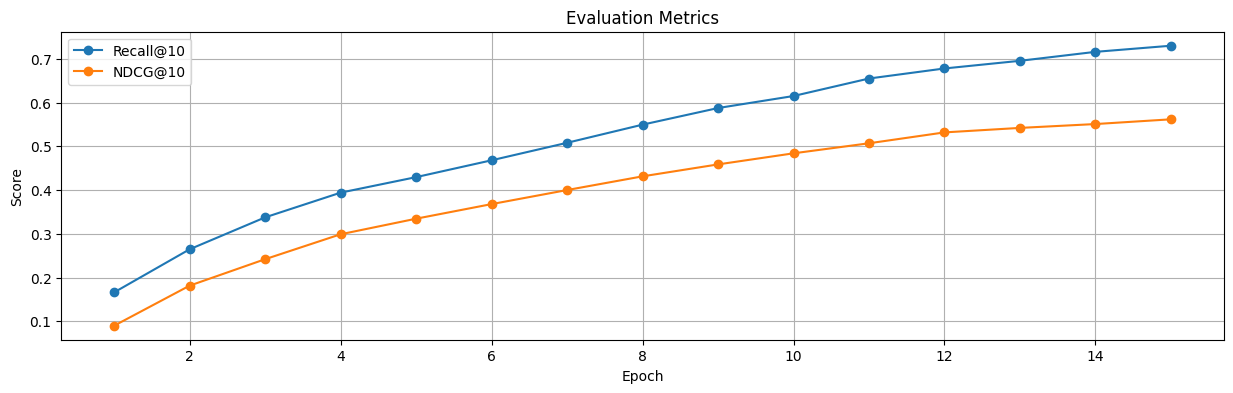

In [1]:
# ─── 1 │ Imports & Config ─────────────────────────────────────────────
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm.auto import tqdm, trange

# ---------------- Hyper‑parameters ----------------
LIKE_TH = 1
EPOCHS = 15
# Embedding dimensions for new features
AGE_EMB_DIM = 16
CLUSTER_EMB_DIM = 16
# Base embedding dimension for users and items
BASE_EMB_DIM = 64 
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ─── 2 │ Load & Preprocess Data ───────────────────────────────────────
# Load all datasets
try:
    ratings_raw = pd.read_csv("data/Ratings.csv")
    users_df = pd.read_csv("data/Users.csv")
    books_meta_df = pd.read_csv("clustered_outputs/clustered_books_metadata.csv")[['ISBN', 'genre_cluster']]
except FileNotFoundError as e:
    print(f"Error loading data files: {e}")
    exit()

# Handle User Age: Fill NaN with median and convert to int
median_age = users_df['Age'].median()
users_df['Age'] = users_df['Age'].fillna(median_age).astype(int)

# Merge the datasets into one
df = pd.merge(ratings_raw, users_df, on='User-ID')
df = pd.merge(df, books_meta_df, on='ISBN')
df = df[df["Book-Rating"] >= LIKE_TH]

# ─── 3 │ Train/Test Split ─────────────────────────────────────────────
df['rank_latest'] = df.groupby(['User-ID'])['Book-Rating'].rank(method='first', ascending=False)
train_df = df[df['rank_latest'] != 1]
test_df = df[df['rank_latest'] == 1]
train_df, test_df = train_df.drop(columns='rank_latest'), test_df.drop(columns='rank_latest')

# ─── 4 │ Encode IDs and Features ──────────────────────────────────────
user2idx = {u: i for i, u in enumerate(df["User-ID"].unique())}
book2idx = {b: i for i, b in enumerate(df["ISBN"].unique())}
age2idx = {a: i for i, a in enumerate(df["Age"].unique())}
cluster2idx = {c: i for i, c in enumerate(df["genre_cluster"].unique())}

# Apply mappings to all dataframes
for df_slice in [train_df, test_df]:
    df_slice["user_idx"] = df_slice["User-ID"].map(user2idx)
    df_slice["book_idx"] = df_slice["ISBN"].map(book2idx)
    df_slice["age_idx"] = df_slice["Age"].map(age2idx)
    df_slice["cluster_idx"] = df_slice["genre_cluster"].map(cluster2idx)

test_df = test_df.dropna().astype({col: int for col in ['user_idx', 'book_idx', 'age_idx', 'cluster_idx']})
test_df = test_df.sample(n=min(len(test_df), 2000), random_state=42)

n_users = len(user2idx)
n_books = len(book2idx)
n_ages = len(age2idx)
n_clusters = len(cluster2idx)

# Define MLP input layer size based on all features
MLP_INPUT_DIM = (BASE_EMB_DIM * 2) + AGE_EMB_DIM + CLUSTER_EMB_DIM
MLP_LAYERS = [MLP_INPUT_DIM, 256, 128, 64]

# ─── 5 │ Dataset with Features ────────────────────────────────────────
class NCFDatasetWithFeatures(Dataset):
    def __init__(self, df, n_books):
        self.users = df["user_idx"].values
        self.items = df["book_idx"].values
        self.ages = df["age_idx"].values
        self.clusters = df["cluster_idx"].values
        self.n_books = n_books
        self.user_item_set = set(zip(self.users, self.items))

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user, item_pos, age, cluster = self.users[idx], self.items[idx], self.ages[idx], self.clusters[idx]
        item_neg = np.random.randint(self.n_books)
        while (user, item_neg) in self.user_item_set:
            item_neg = np.random.randint(self.n_books)
        return user, item_pos, item_neg, age, cluster

def collate_ncf_features(batch):
    users, items_pos, items_neg, ages, clusters = zip(*batch)
    
    users = torch.tensor(users, dtype=torch.long).repeat_interleave(2)
    ages = torch.tensor(ages, dtype=torch.long).repeat_interleave(2)
    clusters = torch.tensor(clusters, dtype=torch.long).repeat_interleave(2)
    
    items = torch.stack([torch.tensor(items_pos, dtype=torch.long), torch.tensor(items_neg, dtype=torch.long)], dim=1).flatten()
    labels = torch.tensor([1, 0] * len(batch), dtype=torch.float32)
    
    return users, items, ages, clusters, labels

train_ds = NCFDatasetWithFeatures(train_df, n_books)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE // 2, shuffle=True, collate_fn=collate_ncf_features, num_workers=0)

# ─── 6 │ Hybrid NCF Model Definition ──────────────────────────────────
class HybridNCF(nn.Module):
    def __init__(self):
        super().__init__()
        # Embeddings for GMF path
        self.gmf_user_emb = nn.Embedding(n_users, BASE_EMB_DIM)
        self.gmf_item_emb = nn.Embedding(n_books, BASE_EMB_DIM)
        
        # Embeddings for MLP path
        self.mlp_user_emb = nn.Embedding(n_users, BASE_EMB_DIM)
        self.mlp_item_emb = nn.Embedding(n_books, BASE_EMB_DIM)
        self.mlp_age_emb = nn.Embedding(n_ages, AGE_EMB_DIM)
        self.mlp_cluster_emb = nn.Embedding(n_clusters, CLUSTER_EMB_DIM)
        
        mlp_modules = []
        for i in range(len(MLP_LAYERS) - 1):
            mlp_modules.append(nn.Linear(MLP_LAYERS[i], MLP_LAYERS[i+1]))
            mlp_modules.append(nn.ReLU())
        self.mlp = nn.Sequential(*mlp_modules)
        
        predict_size = BASE_EMB_DIM + MLP_LAYERS[-1]
        self.predict_layer = nn.Linear(predict_size, 1)

    def forward(self, user, item, age, cluster):
        # GMF Path (only user-item interaction)
        gmf_vector = self.gmf_user_emb(user) * self.gmf_item_emb(item)
        
        # MLP Path (user, item, and their features)
        mlp_user_vec = self.mlp_user_emb(user)
        mlp_item_vec = self.mlp_item_emb(item)
        mlp_age_vec = self.mlp_age_emb(age)
        mlp_cluster_vec = self.mlp_cluster_emb(cluster)
        
        mlp_input = torch.cat([mlp_user_vec, mlp_item_vec, mlp_age_vec, mlp_cluster_vec], dim=-1)
        mlp_vector = self.mlp(mlp_input)
        
        final_vector = torch.cat([gmf_vector, mlp_vector], dim=-1)
        return self.predict_layer(final_vector).squeeze()

model = HybridNCF().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.BCEWithLogitsLoss()

# ─── 7 │ Evaluation Function (Updated for Features) ───────────────────
def evaluate(model, test_df, train_df, top_k=10, n_neg_samples=100):
    model.eval()
    train_history = train_df.groupby("user_idx")["book_idx"].apply(set).to_dict()
    all_book_indices = np.arange(n_books)

    hits = ndcg_sum = total = 0
    with torch.no_grad():
        for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating", leave=False):
            u_idx, pos_b_idx = int(row["user_idx"]), int(row["book_idx"])
            age_idx, cluster_idx = int(row["age_idx"]), int(row["cluster_idx"])
            seen_books = train_history.get(u_idx, set())
            
            neg_b_indices = []
            while len(neg_b_indices) < n_neg_samples:
                samples = np.random.choice(all_book_indices, n_neg_samples)
                neg_b_indices.extend([b for b in samples if b != pos_b_idx and b not in seen_books])
            neg_b_indices = neg_b_indices[:n_neg_samples]

            eval_b_indices = torch.tensor([pos_b_idx] + neg_b_indices, device=DEVICE)
            u_tensor = torch.tensor([u_idx] * len(eval_b_indices), device=DEVICE)
            age_tensor = torch.tensor([age_idx] * len(eval_b_indices), device=DEVICE)
            # For evaluation, we assume the cluster of negative items is unknown or irrelevant, 
            # so we use the positive item's cluster for all. This is a common simplification.
            cluster_tensor = torch.tensor([cluster_idx] * len(eval_b_indices), device=DEVICE)

            scores = model(u_tensor, eval_b_indices, age_tensor, cluster_tensor).cpu().numpy()

            rank = np.sum(scores >= scores[0])
            if rank <= top_k:
                hits += 1
                ndcg_sum += 1 / np.log2(rank + 1)
            total += 1

    return (hits / total, ndcg_sum / total) if total else (0, 0)

# ─── 8 │ Training & Evaluation Loop ──────────────────────────────────
loss_hist, recall_hist, ndcg_hist = [], [], []
for epoch in trange(EPOCHS, desc="Training"):
    model.train()
    epoch_loss = 0.0
    for users, items, ages, clusters, labels in tqdm(train_dl, leave=False, desc=f"Epoch {epoch+1}"):
        users, items, ages, clusters, labels = (t.to(DEVICE) for t in [users, items, ages, clusters, labels])
        
        opt.zero_grad()
        predictions = model(users, items, ages, clusters)
        loss = loss_fn(predictions, labels)
        loss.backward()
        opt.step()
        epoch_loss += loss.item()

    recall, ndcg = evaluate(model, test_df, train_df, top_k=10)
    loss_hist.append(epoch_loss / len(train_dl))
    recall_hist.append(recall)
    ndcg_hist.append(ndcg)
    print(f"Epoch {epoch+1:02d} │ Loss: {loss_hist[-1]:.4f} │ Recall@10: {recall:.4f} │ NDCG@10: {ndcg:.4f}")

# ─── 9 │ Plotting Results ─────────────────────────────────────────────
plt.figure(figsize=(15, 4))
epochs_range = range(1, EPOCHS + 1)
plt.plot(epochs_range, recall_hist, marker='o', label='Recall@10')
plt.plot(epochs_range, ndcg_hist, marker='o', label='NDCG@10')
plt.title("Evaluation Metrics")
plt.xlabel("Epoch"); plt.ylabel("Score")
plt.legend(); plt.grid(True); plt.show()